In [1]:
#Conectarnos a la API de Twitter para recopilar datos.
#utilizar las relaciones tipo 'quién retuitea a quién' del topic Arduino

In [2]:
import tweepy
import pickle
from twitter_secrets import CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify= True) #así espera y notifica

try:
    api.verify_credentials()
    print("Autentificación OK")
except tweepy.TweepError as e:
    print("Falló la autentificación")
    print(e)

Autentificación OK


In [3]:
#recopilación de tweets
#La API nos proporciona hasta 18000 tweets cada 15 minutos (100 tweets para cada una de las 180 peticiones máximo permitidas),

In [4]:
#paginación con objeto cursor: http://docs.tweepy.org/en/v3.5.0/cursor_tutorial.html
#cursor sirve para que no devuelvan tweets repetidos
#api.search(q='Trump',max_id=min(tweets_id)) - continua con la siguiente página

#guardo en formato pickle todos los tweets de arduino y en sqlite
import sqlite3
import pandas as pd

db = sqlite3.connect('tweets.sqlite')

for page_id, page in enumerate(tweepy.Cursor(
    api.search,q='arduino',count=100,
    tweet_mode='extended',
    languages = ['en', 'es']).pages()): # process status here
    
    fn = f'page_{page_id:06d}.pkl'
    with open("./pickle_arduino/"+fn, 'wb') as f:
        pickle.dump(page, f)
    
    #sqlite
    tweets = [str(i._json) for i in page]
    df = pd.DataFrame(tweets)
    df.to_sql("arduino",db,if_exists='append')

Rate limit reached. Sleeping for: 468


In [ ]:
#paginación con objeto cursor: http://docs.tweepy.org/en/v3.5.0/cursor_tutorial.html
import json
for page_id, page in enumerate(tweepy.Cursor(
    api.search,q='Trump',count=100,
    tweet_mode='extended',
    languages = ['en', 'es']).pages()): # process status here
    
    tweets = [i._json for i in page]
    fn = f'page_{page_id:06d}.json'
    with open("./json_trump/"+fn, 'w') as f:
        json.dump(tweets, f)
    
    #sqlite
    tweets_str = [str(i._json) for i in page]
    df = pd.DataFrame(tweets_str)
    df.to_sql("trump",db,if_exists='append')

In [6]:
#necesitaremos unos 100000 tweets
#en cada api.search me devuelve 100 tweets para las 180 permitidas cada 15 minutos
#al usar curso detiene en el último punto, si hiciera de nuevo api.search, repetiria tweets
#curso se debe usar si devuelve más del límite para que lo indexe

In [7]:
#obtener relaciones

In [7]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np

def read_pickled_pages(fn):
    pickle_files = Path('./pickle_arduino/').glob(fn)
    statuses = []
    for page_fn in pickle_files:
        #print(page_fn)
        with open(page_fn, 'rb') as f:
            statuses.extend(pickle.load(f))
    return statuses

def read_json_pages(fn):
    json_files = Path('./json_trump/').glob(fn)
    statuses = []
    for page_fn in json_files:
        #print(page_fn)
        with open(page_fn, 'rb') as f:
            statuses.extend(json.load(f))
    return statuses

def flatten_dict(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

def statuses_to_pandas(statuses):
    data = []
    for status in statuses:
        data.append(flatten_dict(status._json))
    return pd.DataFrame(data)

def statuses_to_pandas_json(statuses):
    data = []
    for status in statuses:
        data.append(flatten_dict(status))
    return pd.DataFrame(data)

def keep_only_user_id_fields(df):
    def is_user_id_column(c):
        return (('user_id' in c.lower() 
                 or ('user_mentions' in c.lower() and 'id' in c.lower()))
                 and not 'str' in c.lower())
    user_columns = sorted([c for c in df.columns if is_user_id_column(c)], key=len)
    df_nx = df[user_columns] 
    return df_nx


def user_df_to_graph(df_nx):

    graph = set()
    for index, row in df_nx.iterrows():
        user_id = row[0]
        assert(not np.isnan(user_id))
        for other_id in row[1:]:
            try:
                if other_id is not None and not np.isnan(other_id):
                    graph.add((int(user_id), int(other_id)))
            except TypeError:
                pass


    df_graph = pd.DataFrame(graph, columns=['src', 'dest'])
    return df_graph

statuses = read_pickled_pages('*.pkl') #lista con los statuses

In [8]:
len(statuses)

16269

In [9]:
tweets_pd = statuses_to_pandas(statuses)

In [10]:
tweets_pd.describe()

,id,display_text_range_0,display_text_range_1,entities_user_mentions_0_id,entities_user_mentions_0_indices_0,entities_user_mentions_0_indices_1,in_reply_to_status_id,in_reply_to_user_id,user_id,user_followers_count,...,quoted_status_entities_user_mentions_5_indices_0,quoted_status_entities_user_mentions_5_indices_1,extended_entities_media_0_additional_media_info_source_user_entities_description_urls_1_indices_0,extended_entities_media_0_additional_media_info_source_user_entities_description_urls_1_indices_1,quoted_status_entities_urls_2_indices_0,quoted_status_entities_urls_2_indices_1,retweeted_status_entities_symbols_0_indices_0,retweeted_status_entities_symbols_0_indices_1,user_entities_description_urls_4_indices_0,user_entities_description_urls_4_indices_1
count,1.626900e+04,16269.000000,16269.000000,1.097500e+04,10975.000000,10975.000000,1.644000e+03,1.700000e+03,1.626900e+04,1.626900e+04,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.266884e+18,2.962751,129.517364,2.343288e+17,7.363098,17.491845,1.266384e+18,3.406208e+17,4.450285e+17,4.384756e+04,...,152.0,165.0,119.0,142.0,78.0,101.0,89.0,93.0,172.0,195.0
std,8.270711e+14,27.548013,57.759935,4.310333e+17,21.582989,21.761236,6.501515e+15,4.983326e+17,5.219213e+17,8.604545e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.265530e+18,0.000000,1.000000,6.136000e+03,0.000000,4.000000,1.114963e+18,6.136000e+03,1.148100e+04,0.000000e+00,...,152.0,165.0,119.0,142.0,78.0,101.0,89.0,93.0,172.0,195.0
25%,1.266144e+18,0.000000,100.000000,3.388454e+07,3.000000,9.000000,1.266075e+18,1.549982e+08,2.929960e+08,9.500000e+01,...,152.0,165.0,119.0,142.0,78.0,101.0,89.0,93.0,172.0,195.0
50%,1.266836e+18,0.000000,139.000000,2.664008e+08,3.000000,13.000000,1.266822e+18,1.479397e+09,3.247039e+09,4.160000e+02,...,152.0,165.0,119.0,142.0,78.0,101.0,89.0,93.0,172.0,195.0
75%,1.267626e+18,0.000000,140.000000,4.760788e+09,3.000000,17.000000,1.267574e+18,9.176154e+17,1.000303e+18,1.470000e+03,...,152.0,165.0,119.0,142.0,78.0,101.0,89.0,93.0,172.0,195.0
max,1.268293e+18,658.000000,932.000000,1.268258e+18,270.000000,278.000000,1.268291e+18,1.268258e+18,1.268258e+18,1.882007e+07,...,152.0,165.0,119.0,142.0,78.0,101.0,89.0,93.0,172.0,195.0


In [11]:
#lista de relaciones id_user (user.id) y en retweeted_status.user.id

In [12]:
relaciones_pd=keep_only_user_id_fields(tweets_pd)

In [13]:
relaciones_pd.describe()

,user_id,in_reply_to_user_id,quoted_status_user_id,retweeted_status_user_id,entities_user_mentions_0_id,entities_user_mentions_1_id,entities_user_mentions_2_id,entities_user_mentions_3_id,entities_user_mentions_4_id,entities_user_mentions_5_id,...,retweeted_status_quoted_status_entities_user_mentions_0_id,retweeted_status_quoted_status_entities_user_mentions_1_id,retweeted_status_quoted_status_entities_user_mentions_2_id,retweeted_status_quoted_status_entities_user_mentions_3_id,extended_entities_media_0_additional_media_info_source_user_id,retweeted_status_quoted_status_entities_media_0_source_user_id,retweeted_status_quoted_status_extended_entities_media_0_source_user_id,quoted_status_extended_entities_media_0_additional_media_info_source_user_id,retweeted_status_extended_entities_media_0_additional_media_info_source_user_id,retweeted_status_quoted_status_extended_entities_media_0_additional_media_info_source_user_id
count,1.626900e+04,1.700000e+03,2.180000e+02,8.754000e+03,1.097500e+04,1.897000e+03,8.120000e+02,4.310000e+02,2.160000e+02,1.480000e+02,...,5.700000e+01,2.700000e+01,1.500000e+01,1.0,6.300000e+01,2.600000e+01,2.600000e+01,1.0,2.200000e+01,2.0
mean,4.450285e+17,3.406208e+17,2.359018e+17,2.277940e+17,2.343288e+17,1.899663e+17,2.051859e+17,1.408829e+17,2.189734e+17,1.037652e+17,...,2.741560e+17,5.222772e+17,4.136819e+08,952092048.0,5.197148e+17,1.204733e+17,1.204733e+17,266400754.0,1.731097e+08,266400754.0
std,5.219213e+17,4.983326e+17,4.461184e+17,4.239321e+17,4.310333e+17,3.999062e+17,4.198263e+17,3.546034e+17,4.448162e+17,2.922969e+17,...,4.890786e+17,5.556438e+17,1.036077e+09,NaN,5.446192e+17,3.436086e+17,3.436086e+17,NaN,1.147604e+08,0.0
min,1.148100e+04,6.136000e+03,8.166530e+05,1.148100e+04,6.136000e+03,5.279000e+03,7.415430e+05,1.334800e+04,6.296300e+04,6.296300e+04,...,6.761030e+05,9.003112e+06,1.361329e+07,952092048.0,3.331578e+07,2.168990e+07,2.168990e+07,266400754.0,3.835592e+07,266400754.0
25%,2.929960e+08,1.549982e+08,2.387986e+08,3.388454e+07,3.388454e+07,7.631604e+07,9.147862e+07,1.219762e+08,9.780696e+07,1.152518e+08,...,2.664008e+08,5.625622e+07,3.436468e+07,952092048.0,2.299427e+08,3.835592e+07,3.835592e+07,266400754.0,3.835592e+07,266400754.0
50%,3.247039e+09,1.479397e+09,2.664008e+08,2.664008e+08,2.664008e+08,2.664008e+08,2.664008e+08,3.514082e+08,3.729218e+08,2.664008e+08,...,3.026663e+08,2.670064e+09,2.664008e+08,952092048.0,4.529092e+09,3.835592e+07,3.835592e+07,266400754.0,2.664008e+08,266400754.0
75%,1.000303e+18,9.176154e+17,3.230520e+09,4.350227e+09,4.760788e+09,3.004269e+09,2.687794e+09,2.072317e+09,2.827404e+09,6.133241e+08,...,2.968165e+09,1.100588e+18,2.664008e+08,952092048.0,1.125153e+18,2.601159e+08,2.601159e+08,266400754.0,2.664008e+08,266400754.0
max,1.268258e+18,1.268258e+18,1.259268e+18,1.268179e+18,1.268258e+18,1.266584e+18,1.256350e+18,1.247259e+18,1.206979e+18,1.232407e+18,...,1.204510e+18,1.139636e+18,4.134255e+09,952092048.0,1.254139e+18,1.147923e+18,1.147923e+18,266400754.0,2.664008e+08,266400754.0


In [14]:
grafo = user_df_to_graph(relaciones_pd)

In [15]:
grafo

,src,dest
0,2933209888,33884545
1,24969935,101584084
2,225856617,10228272
3,2327559914,801472141099208704
4,1000303340209823744,1176339816838922240
...,...,...
13611,3153893019,265588785
13612,2797091621,15608410
13613,2616208171,70266297
13614,2444040222,2372055768


In [16]:
grafo.describe()

,src,dest
count,1.361600e+04,1.361600e+04
mean,3.750326e+17,1.967719e+17
std,5.062043e+17,4.068026e+17
min,1.148100e+04,3.380000e+02
25%,1.985729e+08,3.388454e+07
50%,1.958211e+09,2.664008e+08
75%,9.458984e+17,2.897286e+09
max,1.268258e+18,1.268258e+18


In [17]:
#guardo el grafo en formato csv
grafo.to_csv('grafo_arduino.csv', sep=' ', index=False, header=False)

In [18]:
statuses_json = read_json_pages('*.json') #lista con los statuses

In [19]:
len(statuses_json)

183489

In [20]:
tweets_json_pd = statuses_to_pandas_json(statuses_json)

In [21]:
tweets_json_pd.describe()

,id,display_text_range_0,display_text_range_1,entities_user_mentions_0_id,entities_user_mentions_0_indices_0,entities_user_mentions_0_indices_1,in_reply_to_status_id,in_reply_to_user_id,user_id,user_followers_count,...,retweeted_status_entities_urls_6_indices_0,retweeted_status_entities_urls_6_indices_1,retweeted_status_entities_urls_7_indices_0,retweeted_status_entities_urls_7_indices_1,retweeted_status_entities_urls_8_indices_0,retweeted_status_entities_urls_8_indices_1,retweeted_status_entities_urls_9_indices_0,retweeted_status_entities_urls_9_indices_1,retweeted_status_quoted_status_extended_entities_media_0_additional_media_info_source_user_entities_description_urls_0_indices_0,retweeted_status_quoted_status_extended_entities_media_0_additional_media_info_source_user_entities_description_urls_0_indices_1
count,1.834890e+05,183489.000000,183489.000000,1.690530e+05,169053.000000,169053.000000,2.131300e+04,2.200400e+04,1.834890e+05,1.834890e+05,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.268291e+18,3.408755,130.370191,2.364594e+17,3.916949,15.985667,1.267875e+18,3.199378e+17,4.243524e+17,6.148418e+03,...,178.0,201.0,203.0,226.0,228.0,251.0,253.0,276.0,53.0,76.0
std,3.407292e+12,21.493096,48.972632,4.321003e+17,13.011858,13.179005,1.017624e+16,4.853999e+17,5.156498e+17,1.851634e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.268285e+18,0.000000,5.000000,1.200000e+01,0.000000,2.000000,4.569749e+17,1.200000e+01,2.910000e+02,0.000000e+00,...,178.0,201.0,203.0,226.0,228.0,251.0,253.0,276.0,53.0,76.0
25%,1.268288e+18,0.000000,103.000000,3.580572e+07,3.000000,13.000000,1.268223e+18,3.691991e+07,3.379963e+08,9.700000e+01,...,178.0,201.0,203.0,226.0,228.0,251.0,253.0,276.0,53.0,76.0
50%,1.268291e+18,0.000000,140.000000,4.983529e+08,3.000000,15.000000,1.268278e+18,4.649087e+08,2.865137e+09,3.670000e+02,...,178.0,201.0,203.0,226.0,228.0,251.0,253.0,276.0,53.0,76.0
75%,1.268294e+18,0.000000,140.000000,4.105079e+09,3.000000,17.000000,1.268288e+18,8.229549e+17,9.610122e+17,1.443000e+03,...,178.0,201.0,203.0,226.0,228.0,251.0,253.0,276.0,53.0,76.0
max,1.268296e+18,696.000000,972.000000,1.268288e+18,290.000000,300.000000,1.268296e+18,1.268283e+18,1.268295e+18,4.846501e+07,...,178.0,201.0,203.0,226.0,228.0,251.0,253.0,276.0,53.0,76.0


In [22]:
relaciones_json_pd=keep_only_user_id_fields(tweets_json_pd)
relaciones_json_pd.describe()

,user_id,in_reply_to_user_id,quoted_status_user_id,retweeted_status_user_id,entities_user_mentions_0_id,entities_user_mentions_1_id,entities_user_mentions_2_id,entities_user_mentions_3_id,entities_user_mentions_4_id,entities_user_mentions_5_id,...,retweeted_status_quoted_status_entities_user_mentions_18_id,retweeted_status_quoted_status_entities_user_mentions_19_id,retweeted_status_quoted_status_entities_user_mentions_20_id,retweeted_status_quoted_status_entities_user_mentions_21_id,retweeted_status_quoted_status_entities_media_0_source_user_id,extended_entities_media_0_additional_media_info_source_user_id,retweeted_status_quoted_status_extended_entities_media_0_source_user_id,quoted_status_extended_entities_media_0_additional_media_info_source_user_id,retweeted_status_extended_entities_media_0_additional_media_info_source_user_id,retweeted_status_quoted_status_extended_entities_media_0_additional_media_info_source_user_id
count,1.834890e+05,2.200400e+04,3.774000e+03,1.452310e+05,1.690530e+05,2.645300e+04,1.039900e+04,4.426000e+03,2.292000e+03,1.381000e+03,...,3.000000e+00,3.000000e+00,2.000000e+00,1.0,1.371000e+03,1.927000e+03,1.371000e+03,1.500000e+01,1.500000e+02,1.500000e+01
mean,4.243524e+17,3.199378e+17,2.102778e+17,2.277447e+17,2.364594e+17,2.370091e+17,2.584985e+17,2.756973e+17,2.914849e+17,3.199255e+17,...,8.233300e+17,8.360182e+08,8.180195e+17,42760278.0,8.663079e+16,5.404318e+17,8.663079e+16,3.235788e+17,2.991766e+17,1.343275e+17
std,5.156498e+17,4.853999e+17,4.207066e+17,4.248422e+17,4.321003e+17,4.311516e+17,4.438379e+17,4.569867e+17,4.669129e+17,4.758295e+17,...,7.130320e+17,1.398523e+09,1.357065e+17,NaN,2.866295e+17,5.309487e+17,2.866295e+17,4.847296e+17,4.746441e+17,3.557742e+17
min,2.910000e+02,1.200000e+01,2.461030e+05,7.670000e+02,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,...,2.200545e+09,1.724391e+07,7.220605e+17,42760278.0,6.210300e+04,3.968000e+03,6.210300e+04,2.507388e+07,1.652541e+06,1.663528e+07
25%,3.379963e+08,3.691991e+07,2.560549e+07,3.997997e+07,3.580572e+07,2.507388e+07,2.507388e+07,2.507388e+07,2.507388e+07,2.560549e+07,...,6.158853e+17,2.860713e+07,7.700400e+17,42760278.0,2.507388e+07,2.664201e+07,2.507388e+07,4.640677e+08,2.955751e+08,2.507388e+07
50%,2.865137e+09,4.649087e+08,2.364879e+08,5.429630e+08,4.983529e+08,1.862770e+08,2.175432e+08,2.929293e+08,4.119299e+08,6.127826e+08,...,1.231771e+18,3.997035e+07,8.180195e+17,42760278.0,3.306310e+08,8.438671e+17,3.306310e+08,2.800581e+09,5.513498e+08,2.507388e+07
75%,9.610122e+17,8.229549e+17,2.917052e+09,3.667004e+09,4.105079e+09,3.701542e+09,7.536932e+17,7.498039e+17,8.188972e+17,8.275901e+17,...,1.234995e+18,1.245405e+09,8.659990e+17,42760278.0,4.606184e+08,1.003160e+18,4.606184e+08,7.653545e+17,7.138393e+17,1.156823e+08
max,1.268295e+18,1.268283e+18,1.268281e+18,1.268288e+18,1.268288e+18,1.268279e+18,1.268059e+18,1.268242e+18,1.267573e+18,1.267750e+18,...,1.238219e+18,2.450840e+09,9.139785e+17,42760278.0,1.267593e+18,1.268258e+18,1.267593e+18,1.148213e+18,1.243560e+18,1.087380e+18


In [23]:
grafo_json = user_df_to_graph(relaciones_json_pd)
grafo_json.describe()
grafo_json.to_csv('grafo_json_trump.csv', sep=' ', index=False, header=False)

In [24]:
len(grafo_json)

246622

In [25]:
len(grafo)

13616

In [26]:
grafo

,src,dest
0,2933209888,33884545
1,24969935,101584084
2,225856617,10228272
3,2327559914,801472141099208704
4,1000303340209823744,1176339816838922240
...,...,...
13611,3153893019,265588785
13612,2797091621,15608410
13613,2616208171,70266297
13614,2444040222,2372055768


In [27]:
grafo_json

,src,dest
0,1146565767686701056,73194395
1,1082284429026967552,73194395
2,356438982,55968000
3,992167212,68498034
4,3057818228,3300864488
...,...,...
246617,2381303568,60751951
246618,2519941281,1385878826
246619,1246847906612752384,79379491
246620,155936909,1047598652510937088


In [57]:
#Parte 2 Analizar la red
#Generación de un grafo a partir de los datos capturados.

In [1]:
import networkx as nx
G_arduino = nx.read_edgelist('grafo_arduino.csv',create_using=nx.Graph(),nodetype=int)
G_Trump = nx.read_edgelist('grafo_json_trump.csv',create_using=nx.Graph(),nodetype=int)

In [12]:
#average degree - Grado medio: el número medio de conexiones (de entrada/salida o ambos) de cada nodo de la red.
#densidad del grafo: el ratio entre las conexiones presentes en el grafo y todas las conexiones posibles.
#Diámetro: la ruta más larga entre todas las rutas más cortas de conexión posible entre los nodos dos a dos (máxima distancia entre puntos extremos de la red)
#Transitividad: mide las interconexiones en una red, (responde a la pregunta si A conoce a B y A conoce a C, ¿B y C se conocen?)


print('---- Arduino ----')
print(nx.info(G_arduino))
print(f'Densidad: {nx.density(G_arduino)}')
#diameter = nx.diameter(G_arduino) #Found infinite path length because the graph is not connected
triadic_closure = nx.transitivity(G_arduino)
print(f'Transitividad: {triadic_closure}')

print('\n---- Trump ----')
print(nx.info(G_Trump))
print(f'Densidad: {nx.density(G_Trump)}')
#diameter = nx.diameter(G_Trump) #Found infinite path length because the graph is not connected
triadic_closure = nx.transitivity(G_Trump)
print(f'Transitividad: {triadic_closure}')

---- Arduino ----
Name: 
Type: Graph
Number of nodes: 8827
Number of edges: 13227
Average degree:   2.9969
Densidad: 0.0003395582600415556
Transitividad: 0.008032427455880274

---- Trump ----
Name: 
Type: Graph
Number of nodes: 148971
Number of edges: 245478
Average degree:   3.2956
Densidad: 2.2122898209595923e-05
Transitividad: 0.0011382677385987025


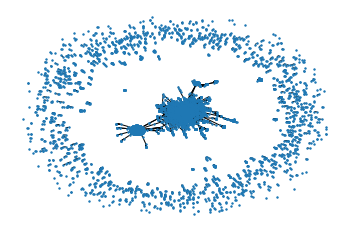

In [14]:
#ejercicio 1 - Visualizar el grafo Arduino
import matplotlib.pyplot as plt
plt.axis('off')
spring_pos = nx.spring_layout(G_arduino)
nx.draw_networkx(G_arduino, pos=spring_pos, cmap=plt.get_cmap('jet'), node_size=2, with_labels=False)

In [ ]:
#ejercicio 1 - Visualizar el grafo Trump
spring_pos = nx.spring_layout(G_Trump)
nx.draw_networkx(G_Trump, pos=spring_pos, cmap=plt.get_cmap('jet'), node_size=2, with_labels=False)
#Tarda demasiado tiempo

In [ ]:
#ejercicio 2 - Simplificar Red. Limpieza de datos: 
#  - Eliminar nodos con pocas conexiones con el resto

In [33]:
deg_arduino = G_arduino.degree
deg_Trump = G_Trump.degree

#Dependiendo de lo que recortemos la red aparecerán más comunidades pequeñas.
#Depende del grado de relacción que establezcamos un grado mínimo es 2 que es que tienen dos relaciones
deg_min_arduino = 3
deg_min_Trump = 10

#Filtra los nodos que tengan un grado inferior a 15 y genera un nuevo grafo sin esos nodos
nodes_arduino = [k[0] for k in deg_arduino if k[1]>=deg_min_arduino]
print(len(nodes_arduino))
G_simple_arduino = G_arduino.subgraph(nodes_arduino)

nodes_Trump = [k[0] for k in deg_Trump if k[1]>=deg_min_Trump]
print(len(nodes_Trump))
G_simple_Trump = G_Trump.subgraph(nodes_Trump)

1615
4738


In [34]:
print('---- Arduino ----')
print(nx.info(G_arduino))
print(f'Densidad: {nx.density(G_arduino)}')
print('\n---- Arduino Simple ----')
print(nx.info(G_simple_arduino))
print(f'Densidad: {nx.density(G_simple_arduino)}')

print('\n---- Trump ----')
print(nx.info(G_Trump))
print(f'Densidad: {nx.density(G_Trump)}')
print('\n---- Trump Simple----')
print(nx.info(G_simple_Trump))
print(f'Densidad: {nx.density(G_simple_Trump)}')

---- Arduino ----
Name: 
Type: Graph
Number of nodes: 8827
Number of edges: 13227
Average degree:   2.9969
Densidad: 0.0003395582600415556

---- Arduino Simple ----
Name: 
Type: Graph
Number of nodes: 1615
Number of edges: 5639
Average degree:   6.9833
Densidad: 0.004326692524006277

---- Trump ----
Name: 
Type: Graph
Number of nodes: 148971
Number of edges: 245478
Average degree:   3.2956
Densidad: 2.2122898209595923e-05

---- Trump Simple----
Name: 
Type: Graph
Number of nodes: 4738
Number of edges: 27149
Average degree:  11.4601
Densidad: 0.002419275860449603


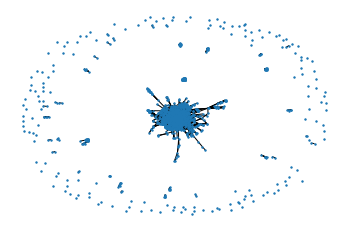

In [35]:
#Visualizar grafo simple Arduino
plt.axis('off')
spring_pos = nx.spring_layout(G_simple_arduino)
nx.draw_networkx(G_simple_arduino, pos=spring_pos, cmap=plt.get_cmap('jet'), node_size=2, with_labels=False)

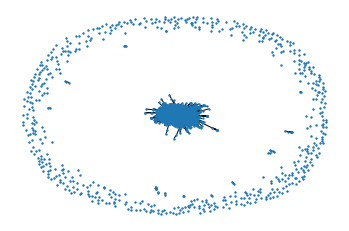

In [36]:
#Visualizar grafo simple Trump
plt.axis('off')
spring_pos = nx.spring_layout(G_simple_Trump)
nx.draw_networkx(G_simple_Trump, pos=spring_pos, cmap=plt.get_cmap('jet'), node_size=2, with_labels=False)

In [37]:
#ejercicio3
#  - Eliminar subgrafos que no estén conectados con el grafo más grande.

# La función nx.connected_components recupera las distintas componentes conexas que hay en nuestro grafo.
# El método subgraph del grafo para crear un nuevo grafo únicamente con la mayor componente conexa detectada.

In [41]:
cc_arduino = nx.connected_components(G_simple_arduino)
cc_Trump = nx.connected_components(G_simple_Trump)

components_size_arduino = [len(c) for c in sorted(cc_arduino, key=len, reverse=True)]
components_size_Trump = [len(c) for c in sorted(cc_Trump, key=len, reverse=True)]

print(max(components_size_arduino))
print(max(components_size_Trump))

largest_cc_arduino = max(nx.connected_components(G_simple_arduino), key=len)
largest_cc_Trump = max(nx.connected_components(G_simple_Trump), key=len)

G_final_arduino = G_simple_arduino.subgraph(largest_cc_arduino)
G_final_Trump = G_simple_Trump.subgraph(largest_cc_Trump)

print('---- Arduino ----')
print(nx.info(G_final_arduino))
print(f'Densidad: {nx.density(G_final_arduino)}')
diameter = nx.diameter(G_final_arduino) #Found infinite path length because the graph is not connected
print(f'diametro: {diameter}') #todos los nodos están conectados y ahora tiene diametro
triadic_closure = nx.transitivity(G_final_arduino)
print(f'Transitividad: {triadic_closure}')

print('\n---- Trump ----')
print(nx.info(G_final_Trump))
print(f'Densidad: {nx.density(G_final_Trump)}')
diameter = nx.diameter(G_final_Trump)
print(f'diametro: {diameter}') #todos los nodos están conectados y ahora tiene diametro
triadic_closure = nx.transitivity(G_final_Trump)
print(f'Transitividad: {triadic_closure}')

1253
4123
---- Arduino ----
Name: 
Type: Graph
Number of nodes: 1253
Number of edges: 4562
Average degree:   7.2817
Densidad: 0.0058160733727871
diametro: 12
Transitividad: 0.05154752350812374

---- Trump ----
Name: 
Type: Graph
Number of nodes: 4123
Number of edges: 27069
Average degree:  13.1307
Densidad: 0.00318552402982382
diametro: 9
Transitividad: 0.033226575178106885


---- Arduino ----


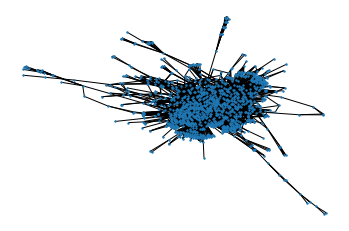

In [45]:
#imprimir los grafos limpios
print('---- Arduino ----')
plt.axis('off')
spring_pos_arduino = nx.spring_layout(G_final_arduino)
nx.draw_networkx(G_final_arduino, pos=spring_pos_arduino, cmap=plt.get_cmap('jet'), node_size=2, with_labels=False)

---- Trump ----


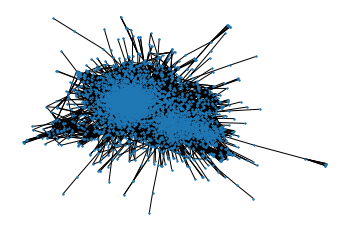

In [46]:
print('---- Trump ----')
plt.axis('off')
spring_pos_Trump = nx.spring_layout(G_final_Trump)
nx.draw_networkx(G_final_Trump, pos=spring_pos_Trump, cmap=plt.get_cmap('jet'), node_size=2, with_labels=False)

In [47]:
#Análisis de la red

In [48]:
#Análisis de los nodos
#  - Identificación de los 'intermediadores' de la red.
#  - Identificación de los 'influencers' de la red.

In [49]:
#ejercicio4 - Analizar la centralidad de la red
#  1. Calcula la centralidad de intermediación de la red y visualiza los nodos con mayor valor.
#  2. Calcula la centralidad de Katz (pagerank o la centralidad de valor propio debeíran dar resultados similares)
#     y visualiza la posición de los nodos de mayor valor.

In [55]:
#Centralidad de intermediación - en cada nodo contamos el número de rutas óptimas (i.e. la ruta más corta entre dos nodos cualesquiera) que pasan por él
#Compute the shortest-path betweenness centrality for nodes.
bt_arduino = nx.betweenness_centrality(G_final_arduino)
bt_Trump = nx.betweenness_centrality(G_final_Trump)

bt_list_arduino = [(id, b) for id, b in bt_arduino.items()]
bt_list_Trump = [(id, b) for id, b in bt_Trump.items()]

bt_list_arduino_ord = sorted(bt_list_arduino, key=lambda b: b[1], reverse=True)
bt_list_Trump_ord = sorted(bt_list_Trump, key=lambda b: b[1], reverse=True)

print('Nodos con mas centralidad de intermediación - Arduino')
for node_id, centrality in bt_list_arduino_ord[:10]:
    print(node_id, centrality)

print('\nNodos con mas centralidad de intermediación - Trump')
for node_id, centrality in bt_list_Trump_ord[:10]:
    print(node_id, centrality)

Nodos con mas centralidad de intermediación - Arduino
266400754 0.6622169359296005
1000303340209823744 0.3037811645561969
284068570 0.08102597946048874
174400537 0.02927001614182289
1473686120 0.029255400353691494
156537915 0.027056628818696978
1127630178644054016 0.025906313199688107
20731304 0.025632378804249085
114819954 0.025165434747702334
115983878 0.023696818738995862

Nodos con mas centralidad de intermediación - Trump
25073877 0.4531864351295578
818927131883356160 0.06743089337734447
1917731 0.05142006978623865
14247236 0.032934964205722055
830908366377611264 0.032571265044083135
822215679726100480 0.017605236125303247
759251 0.017214241811594786
16129920 0.016924593436316172
939091 0.014599222762032401
32871086 0.014242928104967866


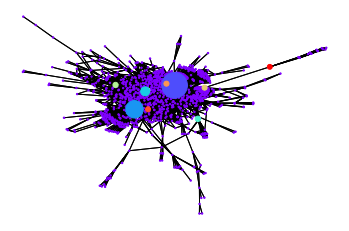

In [74]:
#Visualización
#bt_list_ord - pinto los nodos con más centralidad

top = 10 # dibuja los 10 nodos con mayor centralidad
bt_values = [0]*len(G_final_arduino.nodes())
bt_colors = [0]*len(G_final_arduino.nodes())

z=1
l_nodos = list(G_final_arduino.nodes())
for max_id, max_bt in bt_list_arduino_ord[:top]:
    bt_values[l_nodos.index(max_id)] = 1000*max_bt
    bt_colors[l_nodos.index(max_id)] = z
    z+=1

# Primero dibujamos todos los puntos con un diámetro pequeño
plt.axis("off")
spring_pos_arduino = nx.spring_layout(G_final_arduino)
h = nx.draw_networkx(G_final_arduino, pos = spring_pos_arduino, cmap = plt.get_cmap("rainbow"),node_color = [0]*len(G_final_arduino.nodes()), node_size = [2]*len(G_final_arduino.nodes()), with_labels = False)

# Dibujamos todos los puntos otra vez, pero ahora
# la mayoría tienen diámetro 0 y los 10 con mayor
# centralidad tienen diámetro proporcional a su valor
h = nx.draw_networkx(G_final_arduino, pos = spring_pos_arduino, cmap = plt.get_cmap("rainbow"),node_color = bt_colors, node_size = bt_values, with_labels = False)

--- Trump ---


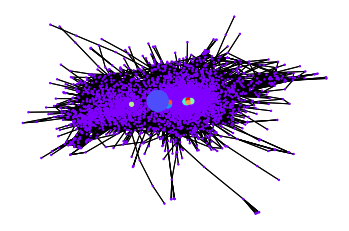

In [75]:
print('--- Trump ---')
top = 10 # dibuja los 10 nodos con mayor centralidad
bt_values = [0]*len(G_final_Trump.nodes())
bt_colors = [0]*len(G_final_Trump.nodes())

z=1
l_nodos = list(G_final_Trump.nodes())
for max_id, max_bt in bt_list_Trump_ord[:top]:
    bt_values[l_nodos.index(max_id)] = 1000*max_bt
    bt_colors[l_nodos.index(max_id)] = z
    z+=1

# Primero dibujamos todos los puntos con un diámetro pequeño
plt.axis("off")
spring_pos_Trump = nx.spring_layout(G_final_Trump)
h = nx.draw_networkx(G_final_Trump, pos = spring_pos_Trump, cmap = plt.get_cmap("rainbow"),node_color = [0]*len(G_final_Trump.nodes()), node_size = [2]*len(G_final_Trump.nodes()), with_labels = False)

# Dibujamos todos los puntos otra vez, pero ahora
# la mayoría tienen diámetro 0 y los 10 con mayor
# centralidad tienen diámetro proporcional a su valor
h = nx.draw_networkx(G_final_Trump, pos = spring_pos_Trump, cmap = plt.get_cmap("rainbow"),node_color = bt_colors, node_size = bt_values, with_labels = False)

In [78]:
# Centralidad de Katz
#ka_arduino = nx.katz_centrality(G_final_arduino)
ka_np_arduino = nx.katz_centrality_numpy(G_final_arduino)
ein_arduino = nx.eigenvector_centrality(G_final_arduino)
pr_arduino = nx.pagerank(G_final_arduino)

#ka_Trump = nx.katz_centrality(G_final_Trump)
ka_np_Trump = nx.katz_centrality_numpy(G_final_Trump)
ein_Trump = nx.eigenvector_centrality(G_final_Trump)
pr_Trump = nx.pagerank(G_final_Trump)

In [82]:
ka_list_arduino = [(id, b) for id, b in ka_np_arduino.items()]
ka_list_Trump = [(id, b) for id, b in ka_np_Trump.items()]

ka_list_arduino_ord = sorted(ka_list_arduino, key=lambda b: b[1], reverse=True)
ka_list_Trump_ord = sorted(ka_list_Trump, key=lambda b: b[1], reverse=True)

print('Nodos con mas centralidad de Katz - Arduino')
for node_id, centrality in ka_list_arduino_ord[:10]:
    print(node_id, centrality)

print('\nNodos con mas centralidad de Katz - Trump')
for node_id, centrality in ka_list_Trump_ord[:10]:
    print(node_id, centrality)

Nodos con mas centralidad de Katz - Arduino
302666251 0.3050575338323939
1473686120 0.18811700102945564
1859962459 0.17117263192365564
728018491 0.17117263192365545
20731304 0.11368854798730683
1257170815881228288 0.10713821645737596
2802797885 0.10584876543558563
1258471161165254656 0.10430282098260639
40785155 0.09498515275936095
4134016874 0.08655769362832856

Nodos con mas centralidad de Katz - Trump
813286 0.16608347103059537
15115280 0.1405165394357488
459872442 0.11850654802751756
27493883 0.11847961630386532
713839291210792960 0.11748840034807463
822215679726100480 0.11034221795691329
2836421 0.10147445919850757
1185190449352499200 0.10139857100136593
22187085 0.08448562005748285
259395895 0.08256603141739782


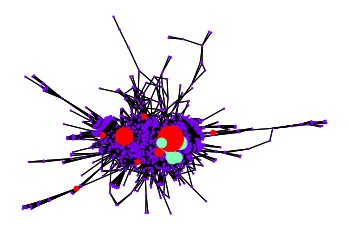

In [92]:
#Visualización
#bt_list_ord - pinto los nodos con más centralidad de Katz - azul y de intermediación - rojo

top = 10 # dibuja los 10 nodos con mayor centralidad
bt_values = [0]*len(G_final_arduino.nodes())
bt_colors = [0]*len(G_final_arduino.nodes())

l_nodos = list(G_final_arduino.nodes())
for max_id, max_bt in ka_list_arduino_ord[:top]:
    bt_values[l_nodos.index(max_id)] = 1000*max_bt
    bt_colors[l_nodos.index(max_id)] = 1

for max_id, max_bt in bt_list_arduino_ord[:top]:
    bt_values[l_nodos.index(max_id)] = 1000*max_bt
    bt_colors[l_nodos.index(max_id)] = 2

# Primero dibujamos todos los puntos con un diámetro pequeño
plt.axis("off")
spring_pos_arduino = nx.spring_layout(G_final_arduino)
h = nx.draw_networkx(G_final_arduino, pos = spring_pos_arduino, cmap = plt.get_cmap("rainbow"),node_color = [0]*len(G_final_arduino.nodes()), node_size = [2]*len(G_final_arduino.nodes()), with_labels = False)

# Dibujamos todos los puntos otra vez, pero ahora
# la mayoría tienen diámetro 0 y los 10 con mayor
# centralidad tienen diámetro proporcional a su valor
h = nx.draw_networkx(G_final_arduino, pos = spring_pos_arduino, cmap = plt.get_cmap("rainbow"),node_color = bt_colors, node_size = bt_values, with_labels = False)

--- Trump ---


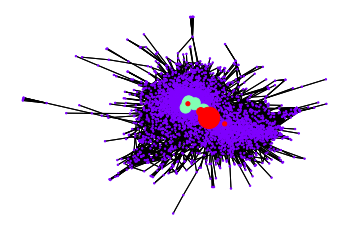

In [93]:
print('--- Trump ---')
top = 10 # dibuja los 10 nodos con mayor centralidad
bt_values = [0]*len(G_final_Trump.nodes())
bt_colors = [0]*len(G_final_Trump.nodes())

l_nodos = list(G_final_Trump.nodes())

for max_id, max_bt in ka_list_Trump_ord[:top]:
    bt_values[l_nodos.index(max_id)] = 1000*max_bt
    bt_colors[l_nodos.index(max_id)] = 1

for max_id, max_bt in bt_list_Trump_ord[:top]:
    bt_values[l_nodos.index(max_id)] = 1000*max_bt
    bt_colors[l_nodos.index(max_id)] = 2

# Primero dibujamos todos los puntos con un diámetro pequeño
plt.axis("off")
spring_pos_Trump = nx.spring_layout(G_final_Trump)
h = nx.draw_networkx(G_final_Trump, pos = spring_pos_Trump, cmap = plt.get_cmap("rainbow"),node_color = [0]*len(G_final_Trump.nodes()), node_size = [2]*len(G_final_Trump.nodes()), with_labels = False)

# Dibujamos todos los puntos otra vez, pero ahora
# la mayoría tienen diámetro 0 y los 10 con mayor
# centralidad tienen diámetro proporcional a su valor
h = nx.draw_networkx(G_final_Trump, pos = spring_pos_Trump, cmap = plt.get_cmap("rainbow"),node_color = bt_colors, node_size = bt_values, with_labels = False)

In [94]:
#ejercicio5 -  Vuelve a conectarte a la API de Twitter y recupera la información de los ids
#  con mayor importancia en la red (puedes fijarte en los 10 o 20 primeros).

In [115]:
import tweepy
from twitter_secrets import CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify= True) #así espera y notifica

try:
    api.verify_credentials()
    print("Autentificación OK")
except tweepy.TweepError as e:
    print("Falló la autentificación")
    print(e)

ids_cent_arduino = bt_list_arduino_ord[:30]
ids_cent_Trump = bt_list_Trump_ord[:30]

ids_cent_ka_arduino = ka_list_arduino_ord[:30]
ids_cent_ka_Trump = ka_list_Trump_ord[:30]

len(ids_cent_arduino)
ids_cent_arduino

Autentificación OK


[(266400754, 0.6622169359296005),
 (1000303340209823744, 0.3037811645561969),
 (284068570, 0.08102597946048874),
 (174400537, 0.02927001614182289),
 (1473686120, 0.029255400353691494),
 (156537915, 0.027056628818696978),
 (1127630178644054016, 0.025906313199688107),
 (20731304, 0.025632378804249085),
 (114819954, 0.025165434747702334),
 (115983878, 0.023696818738995862),
 (44196397, 0.023620666628287816),
 (1006360806307573760, 0.019046212844787098),
 (1190726565073522688, 0.018497324952297934),
 (916945263893155840, 0.0173059547520987),
 (746406081870594048, 0.016763796551540845),
 (62284944, 0.016702592523169253),
 (302666251, 0.015706423446890484),
 (1249209617592139776, 0.01500772515429574),
 (38355920, 0.014956093083340035),
 (34421926, 0.01428697297752852),
 (3107521810, 0.013336311940137333),
 (1142424032794406912, 0.012603075460291142),
 (557138515, 0.011490242556507756),
 (14607140, 0.011409138224246908),
 (1253399363105230848, 0.010979631655993697),
 (710123736175783936, 0.01

In [116]:
print('Usuarios con más importancia en la red (centralidad de intermediación) para Arduino:')
for i, c in ids_cent_arduino:
    try:
        user = api.get_user(i)
        print(f' - {user.name} - {user.screen_name}')
    except tweepy.TweepError as e:
        #print(e)
        #print(f'------ El usuario {i} no existe')
        continue

Usuarios con más importancia en la red (centralidad de intermediación) para Arduino:
 - Arduino - arduino
 - Jacobus Systems - JacobusSystems
 - Pacome Koudou 👨🏾‍💻 - Pac_Kd
 - Hackster.io - Hacksterio
 - robo8080 - robo8080
 - adafruit industries - adafruit
 - Vaselinux - Vaselinux
 - BK Edirne Kampüsü - Bahcesehir22
 - Elon Musk - elonmusk
 - プログラミング素人 - s51517765
 - charlygarcia120 - charlygarcia120
 - Raspberry Pi - Raspberry_Pi
 - sanjosetek - sanjosetek
 - Tyler Glaiel - TylerGlaiel
 - Guillermo ARDUINO - arduinoCNN
 - GaudirProtect - IpsoLook
 - Cyber Security News - CyberSecurityN8
 - Benay Karagöz Tümkaya - benaykaragz
 - hackaday - hackaday
 - Arduíno do Rogério - Rogerio_Arduino
 - YouTube - YouTube
 - M5Stack - M5Stack
 - RobotShop - RobotShop


In [117]:
print('Usuarios con más importancia en la red (centralidad de Katz - autoridad) para Arduino:')
for i, c in ids_cent_ka_arduino:
    try:
        user = api.get_user(i)
        print(f' - {user.name} - {user.screen_name}')
    except tweepy.TweepError as e:
        #print(e)
        #print(f'------ El usuario {i} no existe')
        continue

Usuarios con más importancia en la red (centralidad de Katz - autoridad) para Arduino:
 - Raspberry Pi - Raspberry_Pi
 - Hackster.io - Hacksterio
 - Professa Skinny Shugo - skinnyshugo
 - 🇿🇦 G E E K U L C H A 💻 - Geekulcha
 - adafruit industries - adafruit
 - ESP8266 - ESP8266
 - miami6 - miami6
 - ESP32 - ESP32net
 - Aaron - Aaron54056214
 - Jason Lopez - AtomSoft
 - shivansh Puri - shivanshpuri35
 - Hackster News - HacksterNews
 - James Lewis - baldengineer
 - neo - KasiGeeq
 - Hartmut Wendt - HWHardsoft
 - Moheeb Zara - ANTIFA 🐊 - virgilvox
 - LINK Centre - LINKCentreWits
 - Omphemetse - Omph_metse
 - Sekai - sekaiblock
 - Simanga kaZondumbuzo Mchunu - Simacoder
 - mpumelelo H - mpumelelobigH
 - NCDev Ecosystem: #NCDevTurns5 💻📈 - NCDevEco
 - The Black One - NdinguLucree
 - Lyth Brown - BinoDigital
 - Mixo Ngoveni - 4otune


In [118]:
print('Usuarios con más importancia en la red (centralidad de intermediación) para Trump:')
for i, c in ids_cent_Trump:
    try:
        user = api.get_user(i)
        print(f' - {user.name} - {user.screen_name}')
    except tweepy.TweepError as e:
        #print(e)
        #print(f'------ El usuario {i} no existe')
        continue

Usuarios con más importancia en la red (centralidad de intermediación) para Trump:
 - Donald J. Trump - realDonaldTrump
 - The Hill - thehill
 - Scott Dworkin - funder
 - President Trump - POTUS
 - CNN - CNN
 - Rachel Maddow MSNBC - maddow
 - Joe Biden - JoeBiden
 - Kyle Griffin - kylegriffin1
 - Hannah Natanson - hannah_natanson
 - George Takei - GeorgeTakei
 - ℙ𝕒𝕥𝕥𝕪 💎 - Patty1z
 - GOP - GOP
 - Jonathan Lemire - JonLemire
 - Jim Acosta - Acosta
 - Joy Reid - JoyAnnReid
 - Barack Obama - BarackObama
 - Rick Wilson - TheRickWilson
 - The Washington Post - washingtonpost
 - Erik Larson - exlarson
 - Sharon - floweredog
 - Adam Parkhomenko - AdamParkhomenko
 - David Frum - davidfrum
 - MSNBC - MSNBC
 - Brian Tyler Cohen - briantylercohen
 - Alejandro Alvarez - aletweetsnews


In [119]:
print('Usuarios con más importancia en la red (centralidad de Katz - autoridad) para Arduino:')
for i, c in ids_cent_ka_Trump:
    try:
        user = api.get_user(i)
        print(f' - {user.name} - {user.screen_name}')
    except tweepy.TweepError as e:
        #print(e)
        #print(f'------ El usuario {i} no existe')
        continue

Usuarios con más importancia en la red (centralidad de Katz - autoridad) para Arduino:
 - Barack Obama - BarackObama
 - Palmer Report - PalmerReport
 - Tom Nichols - RadioFreeTom
 - Jon Cooper 🇺🇸 - joncoopertweets
 - Democratic Coalition - TheDemCoalition
 - President Trump - POTUS
 - MSNBC - MSNBC
 - Citizens for Ethics - CREWcrew
 - John Harwood - JohnJHarwood
 - Laura thompson - laura_lthomp
 - Joe Biden - JoeBiden
 - Alejandro Alvarez - aletweetsnews
 - George Conway - gtconway3d
 - Snapchat - Snapchat
 - Kurt Eichenwald - kurteichenwald
 - NBC News - NBCNews
 - Devin Nunes - DevinNunes
 - Elizabeth 🇺🇸 🌊🌊🌊😷 #Biden2020 - beefsquatched
 - Barbara Malmet - B52Malmet
 - The Washington Post - washingtonpost
 - Will they suspend me? - SuspendThePres
 - DGiant - DGiant
 - Sarah Reese Jones - PoliticusSarah
 - Tetsu Kaba 鉄カバ 😷 - TetsuKaba
 - Bizarre Lazar - BizarreLazar
 - NoelCaslerComedy - CaslerNoel


In [ ]:
#ejercicio6 - Detección de comunidades. Analiza las comunidades que aparecen en el grafo
#  - Identificación de comunidades.
#  - Visualizar comunidades

In [ ]:
#ejercicio7 - Análisis
#  1. Recupera la lista de los usuarios con más importancia en cada comunidad 
#     (primero necesitas la lista de usuarios de cada comunidad, y luego ordenarla por su importancia).
#  2. Conéctate a la API de Twitter e identifica los usuarios que aparecen.
#     ¿Se pueden identificar las comunidades que se han generado?
#  3. ¿Qué criterio de centralidad utilizarás para identificar los usuarios más representativos?
#     ¿Qué usuarios aparecen con los mayores valores de centralidad de intermediación?

In [ ]:
'''
#usar la centralidad de katz - para medir la centralidad 
nx.katz_centrallity
nx.katz_centrallity_numpy (usa el algoritmo de numpy)
nx.eigenvector_centrallity (alternativa)
nx.eigenvector_centrallity_numpy (alternativa)
nx.pagerank (alternativa)
'''  
        
#el objetivo es ver comunidades de los grafos
#se ven dos comunidades: alrededor el partido democrata y republicano
#intermediación - las conexiones de Trump y Biden es muy grande porque son usuarios a los que siguen los de un partido y de otro
#autoridad - la cuenta de Trump tiene mucha y la de Joe Biden no tanto
          
        
#Es un análisis del entorno a una instantanea en concreto

#Mandar el notebook y el fichero del grafo y el fichero de datos